In [1]:
using EDM4hep
using EDM4hep.RootIO
# using JetReconstruction
using StaticArrays
using LorentzVectorHEP
using JSON
using ONNXRunTime
# using LinearAlgebra
using StructArrays
# using Plots

In [2]:
using Pkg
Pkg.resolve()
Pkg.develop(Pkg.PackageSpec(path = "/Users/harrywanghc/Developer/2025/HarryFork/JetReconstruction.jl"))
using JetReconstruction
Pkg.status()

  No Changes to `~/Developer/2025/HarryFork/JetReconstruction.jl/examples/flavour-tagging/Project.toml`
  No Changes to `~/Developer/2025/HarryFork/JetReconstruction.jl/examples/flavour-tagging/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Developer/2025/HarryFork/JetReconstruction.jl/examples/flavour-tagging/Project.toml`
  No Changes to `~/Developer/2025/HarryFork/JetReconstruction.jl/examples/flavour-tagging/Manifest.toml`


Status `~/Developer/2025/HarryFork/JetReconstruction.jl/examples/flavour-tagging/Project.toml`
  [7d9f7c33] Accessors v0.1.42
  [c7e460c6] ArgParse v1.2.0
  [944b1d66] CodecZlib v0.7.8
  [6b39b394] CodecZstd v0.8.6
  [eb32b910] EDM4hep v0.4.3
  [4e289a0a] EnumX v1.0.5
  [7073ff75] IJulia v1.27.0
  [682c06a0] JSON v0.21.4
  [44e8cb2c] JetReconstruction v0.4.7 `~/Developer/2025/HarryFork/JetReconstruction.jl`
  [bdcacae8] LoopVectorization v0.12.172
⌃ [f612022c] LorentzVectorHEP v0.1.6
  [3f54b04b] LorentzVectors v0.4.3
  [46d2c3a1] MuladdMacro v0.2.4
  [e034b28e] ONNXRunTime v1.3.1
⌅ [09ab397b] StructArrays v0.6.21
  [56ddb016] Logging v1.11.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [3]:
# Paths to model files
model_dir = "data/wc_pt_7classes_12_04_2023"
onnx_path = joinpath(model_dir, "fccee_flavtagging_edm4hep_wc_v1.onnx")
json_path = joinpath(model_dir, "fccee_flavtagging_edm4hep_wc_v1.json")

# Load the configuration and model
config = JSON.parsefile(json_path)
model = ONNXRunTime.load_inference(onnx_path)

# Display the output classes we'll predict
println("The model predicts these flavor classes:")
for class_name in config["output_names"]
    println(" - ", class_name)
end

The model predicts these flavor classes:
 - recojet_isG
 - recojet_isQ
 - recojet_isS
 - recojet_isC
 - recojet_isB


In [4]:
# Path to ROOT file with EDM4hep data
edm4hep_path = "data/events_080263084.root"
reader = RootIO.Reader(edm4hep_path)

# Get event information
events = RootIO.get(reader, "events")
println("Loaded $(length(events)) events")

# Choose a specific event to analyze (event #13)
event_id = 13
evt = events[event_id]
println("Processing event #$event_id")

# Get reconstructed particles and tracks
recps = RootIO.get(reader, evt, "ReconstructedParticles")
tracks = RootIO.get(reader, evt, "EFlowTrack_1")

# Get needed collections for feature extraction
bz = RootIO.get(reader, evt, "magFieldBz", register = false)[1]
trackdata = RootIO.get(reader, evt, "EFlowTrack")
trackerhits = RootIO.get(reader, evt, "TrackerHits")
gammadata = RootIO.get(reader, evt, "EFlowPhoton")
nhdata = RootIO.get(reader, evt, "EFlowNeutralHadron")
calohits = RootIO.get(reader, evt, "CalorimeterHits")
dNdx = RootIO.get(reader, evt, "EFlowTrack_2")
track_L = RootIO.get(reader, evt, "EFlowTrack_L", register = false)

println("Loaded $(length(recps)) reconstructed particles")
println("Loaded $(length(tracks)) tracks")

Loaded 100000 events
Processing event #13
Loaded 107 reconstructed particles
Loaded 44 tracks


In [5]:
# include("/Users/harrywanghc/Developer/2025/HarryFork/JetReconstruction.jl/src/ReconstructedParticle.jl")
# # Find muons in the event
# muons = RootIO.get(reader, evt, "Muon#0")
# muons_all = ReconstructedParticle.get(muons, recps)
# muons_selected = ReconstructedParticle.sel_p(20.0)(muons_all)
# # TODO: There is a bug in the sel_p function. 
# # When there's only one muon, it should returns a single value instead of a collection but it's buggy.

# # Remove high-momentum muons from the input particles
# recps_no_muons = ReconstructedParticle.remove(recps, muons_selected)
# vrecps = collect(recps_no_muons)

# # Cluster jets using the EEkt algorithm with R=2.0 and p=1.0
# cs = jet_reconstruct(vrecps; p = 1.0, R = 2.0, algorithm = JetAlgorithm.EEKt)

# # Get 2 exclusive jets
# jets = exclusive_jets(cs; njets=2, T=EEJet)

# # For each jet, get its constituent particles
# constituent_indices = [constituent_indexes(jet, cs) for jet in jets]
# jet_constituents = build_constituents_cluster(recps_no_muons, constituent_indices)


In [6]:
# Cluster jets using the EEkt algorithm with R=2.0 and p=1.0
cs = jet_reconstruct(recps; p = 1.0, R = 2.0, algorithm = JetAlgorithm.EEKt)

# Get 2 exclusive jets
jets = exclusive_jets(cs; njets=2, T=EEJet)

# For each jet, get its constituent particles
constituent_indices = [constituent_indexes(jet, cs) for jet in jets]
jet_constituents = build_constituents_cluster(recps, constituent_indices)


2-element Vector{StructVector{ReconstructedParticle}}:
 [ReconstructedParticle(#75, 22, 0.38633013f0, (-0.3512648, 0.14457734, 0.07043707), (0.0, 0.0, 0.0), 0.0f0, 9.40061f-5, 0.0f0, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Cluster#[31], Track#[], ReconstructedParticle#[], ParticleID#[], #0, #0), ReconstructedParticle(#74, 22, 0.2694196f0, (-0.20128913, 0.178003, -0.019609783), (0.0, 0.0, 0.0), 0.0f0, 1.7153065f-5, 0.0f0, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Cluster#[30], Track#[], ReconstructedParticle#[], ParticleID#[], #0, #0), ReconstructedParticle(#77, 22, 0.015476455f0, (-0.007812136, 0.012893902, 0.003498353), (0.0, 0.0, 0.0), 0.0f0, -1.8890213f-6, 0.0f0, Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Cluster#[33], Track#[], ReconstructedParticle#[], ParticleID#[], #0, #0), ReconstructedParticle(#44, 0, 0.5036083f0, (-0.42012292, 0.24007756, -0.0010058009), (0.0, 0.0, 0.0), -1.0f0, 0.13957039f0, 0.0f0, Float32[0.0, 0.0, 0.0, 0.

In [7]:
println("Extracting features for flavor tagging...")
feature_data = extract_features(
    jets, 
    jet_constituents, 
    tracks, 
    bz, 
    track_L, 
    trackdata, 
    trackerhits, 
    gammadata, 
    nhdata, 
    calohits, 
    dNdx
)
println("Step 1: Feature extraction completed.")

model, config = setup_weaver(
    onnx_path,
    json_path
)

println("Step 2: Weaver setup completed.")

input_tensors = prepare_input_tensor(
    jet_constituents,
    jets,
    config,
    feature_data
)

println("Step 3: Input tensor preparation completed.")

println("Running flavor tagging inference...")
weights = get_weights(
    0,  # Thread slot
    feature_data,
    jets,
    jet_constituents,
    config,
    model
)
println("Step 4: Weights retrieval completed.")

jet_scores = Dict{String, Vector{Float32}}()
for (i, score_name) in enumerate(config["output_names"])
    jet_scores[score_name] = get_weight(weights, i-1)
end

println("Jet scores:")
for (name, scores) in jet_scores
    println(" - $name: $(scores[1])")
end

Extracting features for flavor tagging...
Step 1: Feature extraction completed.
Step 2: Weaver setup completed.
Step 3: Input tensor preparation completed.
Running flavor tagging inference...
Step 4: Weights retrieval completed.
Jet scores:
 - recojet_isG: 0.3519804
 - recojet_isB: 0.0028140733
 - recojet_isQ: 0.08182775
 - recojet_isC: 0.022634476
 - recojet_isS: 0.54074335


In [8]:
using DataFrames
using StatsBase
using Plots

In [9]:
function process_events(max_events=1000)
    # Paths to model files
    model_dir = "data/wc_pt_7classes_12_04_2023"
    onnx_path = joinpath(model_dir, "fccee_flavtagging_edm4hep_wc_v1.onnx")
    json_path = joinpath(model_dir, "fccee_flavtagging_edm4hep_wc_v1.json")

    # Load the configuration and model
    config = JSON.parsefile(json_path)
    model = ONNXRunTime.load_inference(onnx_path)

    # Display the output classes we'll predict
    println("The model predicts these flavor classes:")
    for class_name in config["output_names"]
        println(" - ", class_name)
    end

    # Path to ROOT file with EDM4hep data
    edm4hep_path = "data/events_080263084.root"
    reader = RootIO.Reader(edm4hep_path)

    # Get event information
    events = RootIO.get(reader, "events")
    n_events = min(length(events), max_events)
    println("Processing $(n_events) events out of $(length(events)) total events")

    # Create DataFrame to store results - simplified to only include scores
    results = DataFrame(
        event_id = Int[],
        isG = Float32[],
        isB = Float32[],
        isQ = Float32[],
        isC = Float32[],
        isS = Float32[]
    )

    # Process events
    for event_id in 1:n_events
        if event_id % 10 == 0
            println("Processing event #$event_id of $n_events")
        end
        
        try
            evt = events[event_id]
            
            # Get reconstructed particles and tracks
            recps = RootIO.get(reader, evt, "ReconstructedParticles")
            tracks = RootIO.get(reader, evt, "EFlowTrack_1")
            
            # Get needed collections for feature extraction
            bz = RootIO.get(reader, evt, "magFieldBz", register = false)[1]
            trackdata = RootIO.get(reader, evt, "EFlowTrack")
            trackerhits = RootIO.get(reader, evt, "TrackerHits")
            gammadata = RootIO.get(reader, evt, "EFlowPhoton")
            nhdata = RootIO.get(reader, evt, "EFlowNeutralHadron")
            calohits = RootIO.get(reader, evt, "CalorimeterHits")
            dNdx = RootIO.get(reader, evt, "EFlowTrack_2")
            track_L = RootIO.get(reader, evt, "EFlowTrack_L", register = false)
            
            # Cluster jets using the EEkt algorithm with R=2.0 and p=1.0
            cs = jet_reconstruct(recps; p = 1.0, R = 2.0, algorithm = JetAlgorithm.EEKt)
            
            # Get 2 exclusive jets (or less if not enough particles)
            n_jets = min(2, length(inclusive_jets(cs)))
            jets = exclusive_jets(cs; njets=n_jets, T=EEJet)
            
            if length(jets) < 2
                println("Event $event_id: Found only $(length(jets)) jets, skipping")
                continue
            end
            
            # For each jet, get its constituent particles
            constituent_indices = [constituent_indexes(jet, cs) for jet in jets]
            jet_constituents = build_constituents_cluster(recps, constituent_indices)
            
            # Extract features for flavor tagging
            feature_data = extract_features(
                jets, 
                jet_constituents, 
                tracks, 
                bz, 
                track_L, 
                trackdata, 
                trackerhits, 
                gammadata, 
                nhdata, 
                calohits, 
                dNdx
            )
            
            # Setup weaver model if not already done
            model, config = setup_weaver(onnx_path, json_path)
            
            # Prepare input tensors
            input_tensors = prepare_input_tensor(
                jet_constituents,
                jets,
                config,
                feature_data
            )
            
            # Run inference for each jet
            for jet_idx in 1:length(jets)
                weights = get_weights(
                    0,  # Thread slot
                    feature_data,
                    jets,
                    jet_constituents,
                    config,
                    model
                )
                
                # Get scores for each flavor
                scores = Dict{String, Float32}()
                for (i, score_name) in enumerate(config["output_names"])
                    scores[score_name] = get_weight(weights, i-1)[jet_idx]
                end
                
                # Add to results DataFrame - only flavor scores, no jet kinematics
                push!(results, (
                    event_id,
                    scores["recojet_isG"],
                    scores["recojet_isB"],
                    scores["recojet_isQ"],
                    scores["recojet_isC"],
                    scores["recojet_isS"]
                ))
            end
        catch e
            println("Error processing event $event_id: $e")
            continue
        end
    end
    
    println("Processed $(nrow(results) ÷ 2) events successfully with 2 jets each")
    return results
end

process_events (generic function with 2 methods)

In [10]:
results = process_events(1000)

# Display the first few rows of results
first(results, 20)

The model predicts these flavor classes:
 - recojet_isG
 - recojet_isQ
 - recojet_isS
 - recojet_isC
 - recojet_isB
Processing 1000 events out of 100000 total events
Processing event #10 of 1000
Processing event #20 of 1000
Event 20: Found only 1 jets, skipping
Processing event #30 of 1000
Processing event #40 of 1000
Processing event #50 of 1000
Processing event #60 of 1000
Processing event #70 of 1000
Processing event #80 of 1000
Processing event #90 of 1000
Processing event #100 of 1000
Processing event #110 of 1000
Processing event #120 of 1000
Processing event #130 of 1000
Processing event #140 of 1000
Processing event #150 of 1000
Processing event #160 of 1000
Processing event #170 of 1000
Event 175: Found only 1 jets, skipping
Processing event #180 of 1000
Processing event #190 of 1000
Event 199: Found only 1 jets, skipping
Processing event #200 of 1000
Processing event #210 of 1000
Processing event #220 of 1000
Processing event #230 of 1000
Processing event #240 of 1000
Process

Row,event_id,isG,isB,isQ,isC,isS
,Int64,Float32,Float32,Float32,Float32,Float32
1,1,0.337127,0.659087,0.001219,0.002019,0.00054832
2,1,0.337127,0.659087,0.001219,0.002019,0.00054832
3,2,0.618937,0.373939,0.00262202,0.00342763,0.00107362
4,2,0.618937,0.373939,0.00262202,0.00342763,0.00107362
5,3,0.603886,0.387462,0.00318377,0.00406228,0.00140618
6,3,0.603886,0.387462,0.00318377,0.00406228,0.00140618
7,4,0.54699,0.443498,0.00297173,0.00497923,0.00156159
8,4,0.54699,0.443498,0.00297173,0.00497923,0.00156159
9,5,0.397456,0.597143,0.00193421,0.00240517,0.00106199


In [11]:
# # Plot flavor scores for odd index rows (one jet per event)

# # Filter for odd indices (1, 3, 5, 7, ...)
# odd_indices = 1:2:nrow(results)
# odd_data = results[odd_indices, :]

# # Extract event numbers for x-axis
# event_numbers = odd_data.event_id

# # Create the plot
# p_scores = plot(
#     title="Jet Flavor Scores by Event (First Jet Only)",
#     xlabel="Event ID",
#     ylabel="Flavor Score",
#     legend=:topright,
#     linewidth=2,
#     grid=true,
#     gridwidth=1,
#     gridcolor=:gray,
#     gridalpha=0.3,
#     size=(800, 600)
# )

# # Plot each flavor score as a line
# plot!(p_scores, event_numbers, odd_data.isG, 
#       label="Gluon (G)", color=:red, linewidth=2, marker=:circle, markersize=3)

# plot!(p_scores, event_numbers, odd_data.isB, 
#       label="Bottom (B)", color=:blue, linewidth=2, marker=:square, markersize=3)

# plot!(p_scores, event_numbers, odd_data.isQ, 
#       label="Light (Q)", color=:green, linewidth=2, marker=:diamond, markersize=3)

# plot!(p_scores, event_numbers, odd_data.isC, 
#       label="Charm (C)", color=:purple, linewidth=2, marker=:triangle, markersize=3)

# plot!(p_scores, event_numbers, odd_data.isS, 
#       label="Strange (S)", color=:orange, linewidth=2, marker=:star, markersize=3)

# display(p_scores)

In [12]:
# # Alternative: Plot each event in separate subplots

# # Get data for events 1, 3, 5 (odd indices: rows 1, 5, 9)
# event_rows = [1, 5, 9]  # First jet from events 1, 3, 5
# selected_events = results[event_rows, :]

# # Flavor labels and colors
# flavor_labels = ["isG", "isB", "isQ", "isC", "isS"]
# colors = [:red, :blue, :green, :purple, :orange]

# # Create subplot layout
# p_subplots = plot(layout=(1,3), size=(1200, 400))

# # Event 1
# event_1_scores = [selected_events.isG[1], selected_events.isB[1], selected_events.isQ[1], 
#                   selected_events.isC[1], selected_events.isS[1]]
# bar!(p_subplots[1], flavor_labels, event_1_scores, 
#      color=colors, alpha=0.7, title="Event 1", 
#      ylabel="Score Value", legend=false)

# # Event 3  
# event_3_scores = [selected_events.isG[2], selected_events.isB[2], selected_events.isQ[2], 
#                   selected_events.isC[2], selected_events.isS[2]]
# bar!(p_subplots[2], flavor_labels, event_3_scores, 
#      color=colors, alpha=0.7, title="Event 3", legend=false)

# # Event 5
# event_5_scores = [selected_events.isG[3], selected_events.isB[3], selected_events.isQ[3], 
#                   selected_events.isC[3], selected_events.isS[3]]
# bar!(p_subplots[3], flavor_labels, event_5_scores, 
#      color=colors, alpha=0.7, title="Event 5", legend=false)

# # Add value labels on bars
# for subplot in 1:3
#     scores = [event_1_scores, event_3_scores, event_5_scores][subplot]
#     for (i, score) in enumerate(scores)
#         annotate!(p_subplots[subplot], [(i, score + 0.02, 
#                                        text("$(round(score, digits=3))", 8, :center))])
#     end
# end

# display(p_subplots)

In [13]:
# # Plot flavor scores for first three events (1, 3, 5) as histograms

# # Get data for events 1, 3, 5 (odd indices: rows 1, 5, 9)
# event_rows = [1, 5, 9]  # First jet from events 1, 3, 5
# selected_events = results[event_rows, :]

# # Extract the scores for each event
# event_1_scores = [selected_events.isG[1], selected_events.isB[1], selected_events.isQ[1], 
#                   selected_events.isC[1], selected_events.isS[1]]
# event_3_scores = [selected_events.isG[2], selected_events.isB[2], selected_events.isQ[2], 
#                   selected_events.isC[2], selected_events.isS[2]]
# event_5_scores = [selected_events.isG[3], selected_events.isB[3], selected_events.isQ[3], 
#                   selected_events.isC[3], selected_events.isS[3]]

# # Flavor labels
# flavor_labels = ["isG", "isB", "isQ", "isC", "isS"]
# colors = [:red, :blue, :green, :purple, :orange]

# # Create grouped bar chart
# x_positions = 1:5  # Positions for the five flavors

# p_hist = plot(
#     title="Flavor Scores for Events 1, 2, and 3 (First Jet)",
#     xlabel="Flavor Type",
#     ylabel="Score Value",
#     legend=:topright,
#     size=(800, 600),
#     grid=true,
#     gridwidth=1,
#     gridcolor=:gray,
#     gridalpha=0.3
# )

# # Plot bars for each event
# bar_width = 0.25
# bar!(p_hist, x_positions .- bar_width, event_1_scores, 
#      bar_width=bar_width, label="Event 1", color=:lightblue, alpha=0.7)
# bar!(p_hist, x_positions, event_3_scores, 
#      bar_width=bar_width, label="Event 3", color=:lightcoral, alpha=0.7)
# bar!(p_hist, x_positions .+ bar_width, event_5_scores, 
#      bar_width=bar_width, label="Event 5", color=:lightgreen, alpha=0.7)

# # Customize x-axis labels
# plot!(p_hist, xticks=(1:5, flavor_labels))

# # Add value labels on top of bars
# for (i, flavor) in enumerate(flavor_labels)
#     # Event 1
#     annotate!(p_hist, [(i - bar_width, event_1_scores[i] + 0.02, 
#                        text("$(round(event_1_scores[i], digits=3))", 6, :center))])
#     # Event 3
#     annotate!(p_hist, [(i, event_3_scores[i] + 0.02, 
#                        text("$(round(event_3_scores[i], digits=3))", 6, :center))])
#     # Event 5
#     annotate!(p_hist, [(i + bar_width, event_5_scores[i] + 0.02, 
#                        text("$(round(event_5_scores[i], digits=3))", 6, :center))])
# end

# display(p_hist)
# # Save the plot to a file
# savefig(p_hist, "flavor_scores_histogram.png")

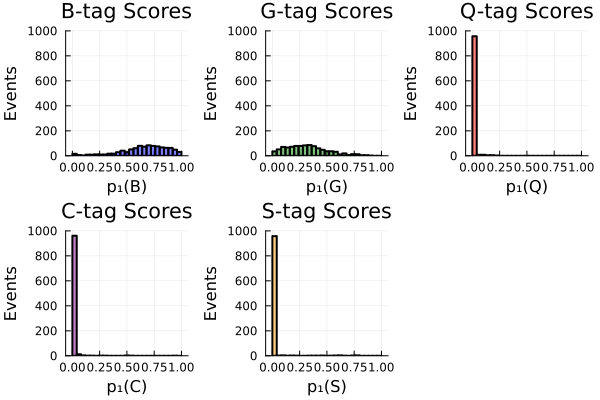

In [ ]:
# Calculate sum of B-scores for each event (simplified)
event_groups = groupby(results, :event_id)
scoresum_data = DataFrame(
    event_id = Int[],
    scoresum_B = Float32[],
    scoresum_G = Float32[],
    scoresum_Q = Float32[],
    scoresum_C = Float32[],
    scoresum_S = Float32[]
)

for group in event_groups
    if nrow(group) == 2
        # Only consider events with exactly 2 jets
        event_id = group.event_id[1]
        scoresum_B = sum(group.isB)/2
        scoresum_G = sum(group.isG)/2
        scoresum_Q = sum(group.isQ)/2
        scoresum_C = sum(group.isC)/2
        scoresum_S = sum(group.isS)/2

        push!(scoresum_data, (event_id, scoresum_B, scoresum_G, scoresum_Q, scoresum_C, scoresum_S))
    end
end

# Display the first few rows of processed data
first(scoresum_data, 5)

# Plot 1: Histogram of B-tag score sum
p1 = histogram(
    scoresum_data.scoresum_B,
    bins=0:0.04:1.0,
    xlabel="p₁(B)",
    ylabel="Events",
    title="B-tag Scores",
    legend=false,
    linewidth=2,
    fillalpha=0.5,
    fillcolor=:blue
)

# Plot 2: Histogram of G-tag score sum
p2 = histogram(
    scoresum_data.scoresum_G,
    bins=0:0.04:1.0,
    xlabel="p₁(G)",
    ylabel="Events",
    title="G-tag Scores",
    legend=false,
    linewidth=2,
    fillalpha=0.5,
    fillcolor=:green
)

# Plot 3: Histogram of Q-tag score sum
p3 = histogram(
    scoresum_data.scoresum_Q,
    bins=0:0.04:1.0,
    xlabel="p₁(Q)",
    ylabel="Events",
    title="Q-tag Scores",
    legend=false,
    linewidth=2,
    fillalpha=0.5,
    fillcolor=:red
)

# Plot 4: Histogram of C-tag score sum
p4 = histogram(
    scoresum_data.scoresum_C,
    bins=0:0.04:1.0,
    xlabel="p₁(C)",
    ylabel="Events",
    title="C-tag Scores",
    legend=false,
    linewidth=2,
    fillalpha=0.5,
    fillcolor=:purple
)

# Plot 5: Histogram of S-tag score sum      
p5 = histogram(
    scoresum_data.scoresum_S,
    bins=0:0.04:1.0,
    xlabel="p₁(S)",
    ylabel="Events",
    title="S-tag Scores",
    legend=false,
    linewidth=2,
    fillalpha=0.5,
    fillcolor=:orange
)

# Plot all 5 histograms in a grid layout, with 
plot(p1, p2, p3, p4, p5, layout=(2, 3))

In [15]:
# # Jet identification plots

# # Create output directory
# output_dir = "outputs/plots/flavor_julia"
# mkpath(output_dir)

# # 1. Determine the identified jet type for each jet (highest score wins)
# identified_types = String[]
# confidence_scores = Float32[]

# for i in 1:nrow(results)
#     scores = [
#         results.isG[i],
#         results.isB[i], 
#         results.isQ[i], 
#         results.isC[i], 
#         results.isS[i]
#     ]
#     types = ["Gluon", "Bottom", "Light", "Charm", "Strange"]
    
#     # Find the type with highest score
#     max_idx = argmax(scores)
#     push!(identified_types, types[max_idx])
#     push!(confidence_scores, scores[max_idx])
# end

# # Count occurrences of each identified jet type
# type_counts = countmap(identified_types)
# jet_types = collect(keys(type_counts))
# counts = collect(values(type_counts))

# # Plot 2: Bar chart of identified jet types
# p2 = bar(
#     jet_types,
#     counts,
#     title="Jet Type Identification Results",
#     xlabel="Identified Jet Type",
#     ylabel="Number of Jets",
#     legend=false,
#     fillcolor=[:red, :blue, :green, :purple, :orange][1:length(jet_types)],
#     alpha=0.7,
#     rotation=45
# )

# # Add percentage labels on top of bars
# for (i, count) in enumerate(counts)
#     percentage = round(count / sum(counts) * 100, digits=1)
#     annotate!(p2, [(i, count + sum(counts)*0.01, text("$(percentage)%", 8, :center))])
# end

# # Plot 3: Confidence distribution for each jet type
# p3 = plot(
#     title="Identification Confidence by Jet Type",
#     xlabel="Confidence Score",
#     ylabel="Density",
#     legend=:topright
# )

# colors = [:red, :blue, :green, :purple, :orange]
# for (i, jet_type) in enumerate(unique(identified_types))
#     type_confidences = confidence_scores[identified_types .== jet_type]
#     histogram!(p3, type_confidences, 
#                alpha=0.5, 
#                normalize=:pdf,
#                label=jet_type,
#                color=colors[i],
#                bins=0:0.02:1)
# end

# # Plot 4: Score distributions for all flavor types
# p4 = plot(
#     title="Raw Score Distributions for All Flavor Types",
#     xlabel="Score Value",
#     ylabel="Density",
#     legend=:topright
# )

# flavors = ["isG", "isB", "isQ", "isC", "isS"]
# flavor_labels = ["Gluon", "Bottom", "Light", "Charm", "Strange"]
# colors = [:red, :blue, :green, :purple, :orange]

# for (i, (flavor, label, color)) in enumerate(zip(flavors, flavor_labels, colors))
#     histogram!(p4, results[!, flavor], 
#                alpha=0.4, 
#                normalize=:pdf,
#                label=label,
#                color=color,
#                bins=0:0.02:1)
# end

# # Plot 5: Confusion-like plot showing score distributions for identified types
# p5 = plot(
#     title="Score Distributions by Identified Type",
#     xlabel="Score Value", 
#     ylabel="Density",
#     legend=:topright,
#     layout=(2,3),
#     size=(1200, 800)
# )

# for (subplot_idx, jet_type) in enumerate(unique(identified_types))
#     type_mask = identified_types .== jet_type
    
#     # Plot all flavor scores for jets identified as this type
#     for (i, (flavor, label, color)) in enumerate(zip(flavors, flavor_labels, colors))
#         type_scores = results[type_mask, flavor]
#         histogram!(p5[subplot_idx], type_scores,
#                    alpha=0.5,
#                    normalize=:pdf,
#                    label=label,
#                    color=color,
#                    bins=0:0.05:1,
#                    title="Jets ID'd as $jet_type")
#     end
# end

# # Display summary statistics
# println("\nJet Identification Summary:")
# println("="^50)
# total_jets = length(identified_types)
# for (jet_type, count) in sort(collect(type_counts), by=x->x[2], rev=true)
#     percentage = round(count / total_jets * 100, digits=1)
#     avg_confidence = round(mean(confidence_scores[identified_types .== jet_type]), digits=3)
#     println("$jet_type: $count jets ($(percentage)%) - Avg confidence: $avg_confidence")
# end

# # Save plots
# savefig(p2, joinpath(output_dir, "jet_identification.png"))
# savefig(p3, joinpath(output_dir, "identification_confidence.png"))
# savefig(p4, joinpath(output_dir, "score_distributions.png"))
# savefig(p5, joinpath(output_dir, "scores_by_identified_type.png"))